In [92]:
# %load ../standard_import.txt
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp


from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import KFold

%matplotlib inline
plt.style.use('seaborn')

%cd C:\Users\yo\Documents\ML_and_Python\ML_and_Python_books\ISLR\ISLR-python\Notebooks\Data

C:\Users\yo\Documents\ML_and_Python\ML_and_Python_books\ISLR\ISLR-python\Notebooks\Data


# Feature Selection on Hitters data

In [48]:
hitters = pd.read_csv('Hitters.csv', index_col=0).dropna()
# hitters.index.name = 'Player'
hitters.dropna(inplace=True)
hitters.isnull().values.any()
hitters.isnull().sum()
hitters.NewLeague.value_counts()

A    141
N    122
Name: NewLeague, dtype: int64

In [36]:
hitters.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague'],
      dtype='object')

In [49]:
hitters['League'] = pd.factorize(hitters['League'])[0]
hitters['Division'] = pd.factorize(hitters['Division'])[0]
hitters['NewLeague'] = pd.factorize(hitters['NewLeague'])[0]
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,0,0,632,43,10,475.0,0
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,1,0,880,82,14,480.0,1
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,0,1,200,11,3,500.0,0
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,0,1,805,40,4,91.5,0
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,1,0,282,421,25,750.0,1


In [51]:
# construct a baseline regressor with all features
collist = [col for col in hitters.columns if col != 'Salary']
X = hitters[collist]
y = hitters.Salary

reg = LinearRegression()
reg.fit(X, y)
ypred = reg.predict(X)
np.sqrt(mean_squared_error(y, ypred))


303.34447253531613

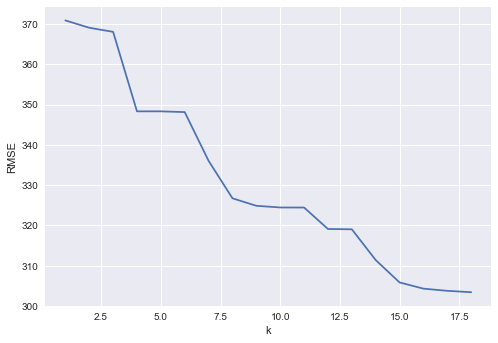

In [73]:
# Feature selection using sklearn SelectKBest
mses = []
# scores = []
nfeatures = range(1, len(collist))

for nfeature in nfeatures:
    # compute MSE for different values of k (top features)
    selector = SelectKBest(f_regression, k=nfeature)
    
    selector.fit(X, y)
    selected = selector.get_support()
 
    feats = [col for (col,sel) in zip(collist, selected) if sel]
    
    reg = LinearRegression()
    
    X_r = hitters[feats]
    reg.fit(X_r, y)
    ypred = reg.predict(X_r)
    scores.append(reg.score(X_r, y))
    mses.append(np.sqrt(mean_squared_error(ypred, y)))
plt.plot(nfeatures, mses)
plt.xlabel("k")
plt.ylabel("RMSE")
# plt.plot(nfeatures, scores)
# plt.xlabel("k")
# plt.ylabel("Score")


# Model Selection by Cross-Validation
The RMSE falls as the number of features increase - this is expected because we are computing the RMSE off the training set (overfitting). We will now use 10-fold cross validation on each model to calculate a cross-validation MSE which will give us a better idea of the best feature size to use for the problem

KFold(n_splits=10, random_state=None, shuffle=False)


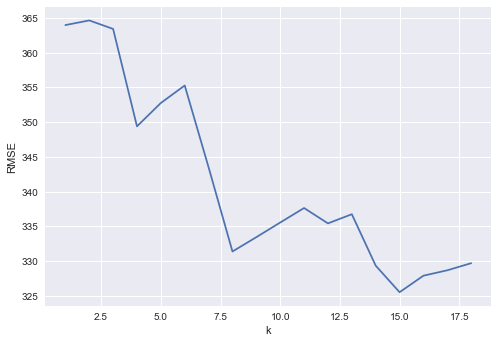

In [80]:
cv_errors = []
kfold = KFold(n_splits=10)
print(kfold)
nfeatures = range(1, len(collist))
for nfeature in nfeatures:
    # build model with varying number of features
    selector = SelectKBest(f_regression, k=nfeature)
    selector.fit(X, y)
    selected = selector.get_support()
    feats = [col for (col,sel) in zip(collist, selected) if sel]
    X_r = hitters[feats].values
    y = hitters["Salary"].values
    rmses = []
    for train, test in kfold.split(X_r):
        # each model is cross validated 10 times
        Xtrain, ytrain, Xtest, ytest = X_r[train], y[train], X_r[test], y[test]   
        reg = LinearRegression()
        reg.fit(Xtrain, ytrain)
        ypred = reg.predict(Xtest)
        rmses.append(np.sqrt(mean_squared_error(ytest, ypred)))
    cv_errors.append(np.mean(rmses))
plt.plot(nfeatures, cv_errors)
plt.xlabel("k")
plt.ylabel("RMSE")

# Ridge regression and Lasso

In [87]:
def cross_validate(X, y, nfolds, reg_name):
    rmses = []
    kfold = KFold(n_splits=nfolds)
    for train, test in kfold.split(X):
        Xtrain, ytrain, Xtest, ytest = X[train], y[train], X[test], y[test]
        reg = None
        if reg_name == "ridge":
            reg = Ridge()
        elif reg_name == "lasso":
            reg = Lasso(max_iter=500000)
        else:
            reg = LinearRegression()
        reg.fit(Xtrain, ytrain)
        ypred = reg.predict(Xtest)
        rmses.append(np.sqrt(mean_squared_error(ytest, ypred)))
    return np.mean(rmses)

collist = [col for col in hitters.columns if col != "Salary"]
X = hitters[collist].values
y = hitters["Salary"].values
rmse_baseline = cross_validate(X, y, 10, "baseline")
rmse_ridge = cross_validate(X, y, 10, "ridge")
rmse_lasso = cross_validate(X, y, 10, "lasso")
(rmse_baseline, rmse_ridge, rmse_lasso)

(331.00425667935792, 330.72572506106633, 330.09692222862941)

Finally, we attempt to find an optimum value of alpha for the Lasso regressor using cross-validation.

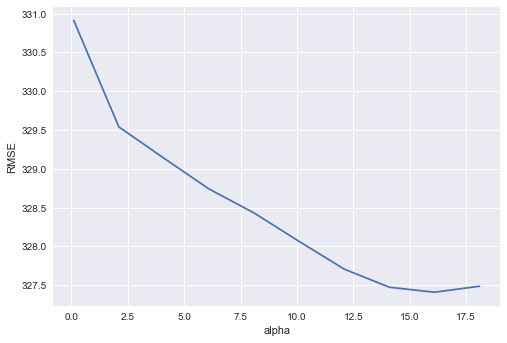

In [90]:
cv_errors = []
alphas = [0.1 * alpha for alpha in range(1, 200, 20)]
kfold = KFold(n_splits=10)
for alpha in alphas:
    rmses = []
    for train, test in kfold.split(X):
        Xtrain, ytrain, Xtest, ytest = X[train], y[train], X[test], y[test]
        reg = Lasso(max_iter=10000, alpha=alpha)
        reg.fit(Xtrain, ytrain)
        ypred = reg.predict(Xtest)
        rmses.append(np.sqrt(mean_squared_error(ytest, ypred)))
    cv_errors.append(np.mean(rmses))
plt.plot(alphas, cv_errors)
plt.xlabel("alpha")
plt.ylabel("RMSE")

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


ValueError: x and y must have same first dimension, but have shapes (100,) and (1, 19)

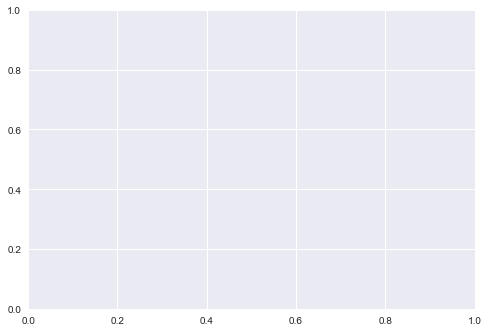

In [105]:
alphas = 10**np.linspace(10,-2,100)*0.5
lasso = Lasso(max_iter=10000, normalize=True)
coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(Xtrain), ytrain)
    coefs.append(lasso.coef_)
    ax = plt.gca()
    ax.plot(alphas*2, coefs)
    ax.set_xscale('log')
    plt.axis('tight')
    plt.xlabel('alpha')
    plt.ylabel('weights')

In [101]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(Xtrain, ytrain)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(Xtrain, ytrain)
mean_squared_error(ytest, lasso.predict(Xtest))

111275.50174604177

15